In [8]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from adjustText import adjust_text

from Bio import SeqIO

from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [9]:
datadir = '../data/dnaPipeTE-out'
dnapipete_data = {sp: f'{datadir}/{sp}/Counts.txt' for sp in os.listdir(datadir)}

In [10]:
def read_counts(countfile):
    count_df = pd.read_csv(countfile, sep='\t', header=None, names=['teclass', 'readcount'])
    return count_df

def count_finz_znf(species):
    count = 0
    with open('../data/seqs/cypriniformes_augustus_finz.fa') as infile:
        for line in infile:
            if line.startswith(f'>{species}'):
                count += 1
    return count

def count_finz_exons(species):
    count = 0
    with open(f'../data/blast-out/{species}_finz_locs.out') as infile:
        for line in infile:
            count += 1
    return count

In [16]:
count_dfs = []
for sp, val in dnapipete_data.items():
    count_df = read_counts(val)
    count_df['species'] = sp
    count_df['finz_znf'] = count_finz_znf(sp)
    count_df['finz_exons'] = count_finz_exons(sp)
    count_dfs.append(count_df)

count_df = pd.concat(count_dfs)
count_df = count_df.pivot_table(index=['species', 'finz_exons', 'finz_znf'], 
                                columns='teclass', 
                                values='readcount') \
    .sort_values('finz_znf') \
    .reset_index()
count_df['Unknown'] = count_df.na + count_df.others
count_df = count_df.drop(['Others', 'Tandem_repeats', 'na', 'others', 'rRNA', 'MITE', 'Simple_repeat'], axis=1)
count_df['interspersed'] = count_df.DNA + count_df.LTR + count_df.LINE + count_df.SINE + count_df.Helitron + count_df.Unknown
for teclass in ['DNA', 'Helitron', 'LINE', 'LTR', 'SINE', 'Low_Complexity', 'Satellite', 'Unknown', 'interspersed', 'Total']:
    count_df[teclass] = count_df[teclass]/count_df['Total']*100 

print(count_df.head())
count_df.to_csv('../data/finz_te_counts.txt', sep='\t', header=True, index=False)

teclass                     species  finz_exons  finz_znf        DNA  \
0              Triplophysa_tibetana          35         0  11.535100   
1            Triplophysa_siluroides          14         0  11.144761   
2                Danionella_dracula          11         0   5.642604   
3            Danionella_translucida          12         4   7.711250   
4        Poropuntius_huangchuchieni         322         8   9.116787   

teclass  Helitron      LINE       LTR  Low_Complexity      SINE  Satellite  \
0        0.353564  4.109580  4.397636        0.046156  0.414028   0.150996   
1        0.165809  2.899348  4.312603        0.036850  0.296132   0.086445   
2        0.563075  3.757688  4.499909        0.005209  0.621013   0.050368   
3        1.695768  2.048340  2.897715        0.002425  0.048013   0.227442   
4        0.203333  1.180123  1.830937        0.037739  0.166368   1.400176   

teclass  Total   Unknown  interspersed  
0        100.0  8.651206     29.461116  
1        100.0  

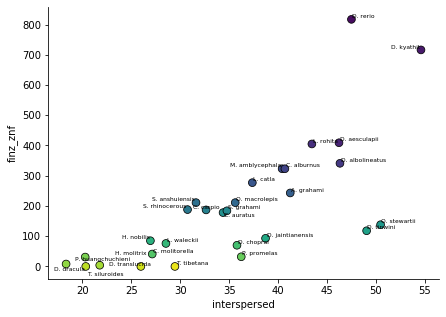

SpearmanrResult(correlation=0.7623862079453566, pvalue=1.536263649755955e-06)


In [18]:
column = 'interspersed'
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=count_df, 
                x=column, 
                y='finz_znf',
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=60,
                ax=ax)
ax.get_legend().remove()

labels = []
for row in count_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1][column], row[1]['finz_znf'], label, size=6, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()
print(stats.spearmanr(count_df[column], 
                      count_df['finz_znf']))
fig.savefig('../figs/finz_znf_corr.pdf', bbox_inches='tight')

A possible explanation for some of the noise in the correlation is genome assembly quality. Since the finz-znfs are normally present on specific, highly repetitive chromosomes, it is possible that low numbers of predicted genes could be due to collapsing or fragmentation of these regions. To test this, we will look at the correlation between N50 and finz count.

In [19]:
def calc_N50(genomefile):
    contiglens = []
    for record in SeqIO.parse(genomefile, 'fasta'):
        contiglens.append(len(record.seq))
    contiglens = sorted(contiglens, reverse=True)
    gsize = sum(contiglens)
    i, currentsize = 0, 0
    while currentsize <= gsize*0.5:
        currentsize += contiglens[i]
        i += 1
    return contiglens[i]

with open('../data/species_genomes.txt') as infile:
    genomes = {line.split()[0]: f'/Users/jonwells/Genomes/Cypriniformes/ncbi-genomes-2020-07-09/{line.split()[1]}' for line in infile}

n50s = []
for species, genomefile in genomes.items():
    n50s.append((species, calc_N50(genomefile)))
n50_df = pd.DataFrame(n50s, columns=['species', 'N50'])
n50_df = n50_df.merge(count_df, on='species')
print(n50_df.head())

                        species      N50  finz_exons  finz_znf        DNA  \
0           Pimephales_promelas    60365         393        32  17.983488   
1               Cyprinus_carpio  7653411         664       187  13.901122   
2  Sinocyclocheilus_anshuiensis  1282074         536       211  14.814240   
3  Sinocyclocheilus_rhinocerous   945578         535       188  14.103385   
4      Sinocyclocheilus_grahami  1156011         641       184  15.798656   

   Helitron      LINE       LTR  Low_Complexity      SINE  Satellite  Total  \
0  0.346771  1.834706  2.983876        0.044337  0.226264   1.198272  100.0   
1  0.719657  4.009053  3.482556        0.053705  0.409140   1.808048  100.0   
2  0.349348  2.304985  3.698811        0.056139  0.360871   2.071782  100.0   
3  0.308016  2.142732  3.394562        0.032997  0.283832   2.070005  100.0   
4  0.263180  2.629399  4.357701        0.039877  0.352033   1.939387  100.0   

     Unknown  interspersed  
0  12.860465     36.235571  
1  1

NameError: name 'n50_df' is not defined

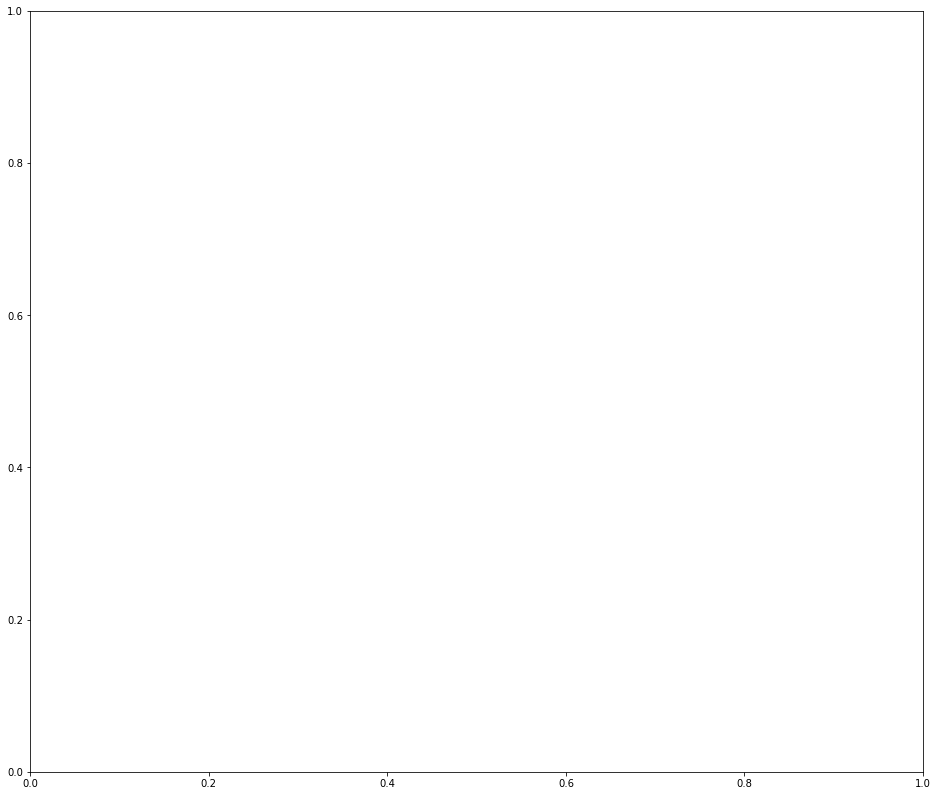

In [7]:
fig, ax = plt.subplots(figsize=(16, 14))
# sns.scatterplot(data=n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])], 
sns.scatterplot(data=n50_df, 
                x='N50', 
                y='finz',
                hue='species',
                palette='viridis_r',
                edgecolor='k',
                s=120,
                ax=ax)
ax.get_legend().remove()
labels = []
for row in n50_df.iterrows():
    label = row[1]['species'].split('_')[0][0] +'. '+ row[1]['species'].split('_')[1]
    labels.append(ax.text(row[1]['N50'], row[1]['finz'], label, size=8, va='center', ha='center'))
adjust_text(labels)

sns.despine()
plt.show()


print(stats.spearmanr(n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].N50, n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].finz))
print(stats.pearsonr(n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].N50, n50_df.loc[~n50_df.species.isin(['Danio_rerio', 'Danio_aesculapii', 'Danio_kyathit'])].finz))

In [ ]:
print()